In [ ]:
# import pandas as pd
# from ast import literal_eval

# if not isinstance(df_reviews['category'].iloc[0], list):
#     df_reviews['category'] = df_reviews['category'].apply(lambda x: literal_eval(x) if pd.notna(x) else [])

# pharmacy_rows = df_reviews[df_reviews['category'].apply(lambda x: 'Hotel' in x)]

In [1]:
import pandas as pd
import numpy as np
import math

In [2]:
from google.colab import auth
auth.authenticate_user()

In [3]:
from google.cloud import storage

project_id = "sharp-matter-449521-u2"
!gcloud config set project {project_id}

Updated property [core/project].


In [4]:
!pip install pyspark py4j
!wget -P /usr/lib/spark/jars/ https://storage.googleapis.com/hadoop-lib/gcs/gcs-connector-hadoop3-latest.jar

--2025-04-22 16:57:13--  https://storage.googleapis.com/hadoop-lib/gcs/gcs-connector-hadoop3-latest.jar
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.188.207, 64.233.189.207, 108.177.97.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.188.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40713341 (39M) [application/java-archive]
Saving to: ‘/usr/lib/spark/jars/gcs-connector-hadoop3-latest.jar’

gcs-connector-hadoo 100%[===================>]  38.83M  18.4MB/s    in 2.1s    

2025-04-22 16:57:15 (18.4 MB/s) - ‘/usr/lib/spark/jars/gcs-connector-hadoop3-latest.jar’ saved [40713341/40713341]



In [5]:
from pyspark.sql import SparkSession

In [6]:
spark = SparkSession.builder \
    .appName("BigDataProcessing") \
    .config("spark.jars", "/usr/lib/spark/jars/gcs-connector-hadoop3-latest.jar") \
    .config("spark.hadoop.fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem") \
    .config("spark.hadoop.fs.gs.auth.service.account.enable", "true") \
    .getOrCreate()

In [ ]:
import pandas as pd
df_sample_pd = pd.read_parquet("gs://final_dataset_dat490/sample_reviews_stratified_10k.parquet")
df_sample_pd = df_sample_pd.sort_values(["gmap_id", "timestamp"]).reset_index(drop=True)
df_sample_pd.columns

Index(['gmap_id', 'customer_name', 'rating', 'reviews', 'time', 'avg_rating',
       'category', 'latitude', 'longitude', 'business_name', 'num_of_reviews',
       'state', 'standard_category', 'Monday', 'Tuesday', 'Wednesday',
       'Thursday', 'Friday', 'Saturday', 'Sunday', 'timestamp', 'week',
       'month', 'year', 'time_seconds', 'review_length', 'length_bucket'],
      dtype='object')

In [ ]:
df_sample_pd['year'].unique()

array([2021, 2020, 2016, 2019, 2018, 2017, 2015, 2013, 2012, 2014, 2011],
      dtype=int32)

In [ ]:
df_sample_pd.groupby('year')['gmap_id'].count()

,gmap_id
year,
2011,1
2012,5
2013,5
2014,4
2015,10
2016,92
2017,275
2018,586
2019,1190


In [ ]:
df_sample_pd.groupby('standard_category')['gmap_id'].count()

,gmap_id
standard_category,
Automotive,553
Bakery,108
Bar,199
Beauty & Wellness,575
Business Services,355
Cafe,150
Construction,14
Consulting,37
Education,52


In [ ]:
import torch
print(torch.cuda.is_available())

True


In [ ]:
from transformers import pipeline
from tqdm import tqdm

tqdm.pandas()

# Zero-shot classification pipeline with BART
zero_shot_classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=0)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
candidate_labels = ["positive", "neutral", "negative"]

# Get the reviews as a list
texts = df_sample_pd["reviews"].tolist()

# Run batch inference
results = zero_shot_classifier(texts, candidate_labels)

# Extract top predicted labels
bart_labels = [res["labels"][0].capitalize() for res in results]

# Assign back to the DataFrame
df_sample_pd["bart_label"] = bart_labels


KeyboardInterrupt: 

In [ ]:
df_sample_pd.head()

In [ ]:
df_sample_pd.columns

Index(['gmap_id', 'customer_name', 'rating', 'reviews', 'time', 'avg_rating',
       'category', 'latitude', 'longitude', 'business_name', 'num_of_reviews',
       'state', 'standard_category', 'Monday', 'Tuesday', 'Wednesday',
       'Thursday', 'Friday', 'Saturday', 'Sunday', 'timestamp', 'week',
       'month', 'year', 'time_seconds', 'review_length', 'length_bucket',
       'bart_label'],
      dtype='object')

In [ ]:
!pip install --upgrade openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.4/644.4 kB 9.9 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.70.0
    Uninstalling openai-1.70.0:
      Successfully uninstalled openai-1.70.0


In [ ]:
from openai import OpenAI
from google.colab import userdata

client = OpenAI(api_key=userdata.get("openai_api_key"))

In [ ]:
from openai import OpenAI
from google.colab import userdata

client = OpenAI(api_key=userdata.get("openai_api_key"))

models = client.models.list()

for model in models.data:
    print(model.id)

gpt-4o-audio-preview-2024-12-17
dall-e-3
dall-e-2
gpt-4o-audio-preview-2024-10-01
gpt-4o-realtime-preview-2024-10-01
gpt-4o-realtime-preview
babbage-002
tts-1-hd-1106
text-embedding-3-large
gpt-4
text-embedding-ada-002
tts-1-hd
gpt-4o-mini-audio-preview
gpt-4-0125-preview
gpt-4o-audio-preview
gpt-4-turbo-preview
o1-preview-2024-09-12
gpt-4o-mini-realtime-preview
gpt-4o-mini-realtime-preview-2024-12-17
gpt-3.5-turbo-instruct-0914
gpt-4o-mini-search-preview
tts-1-1106
davinci-002
gpt-3.5-turbo-1106
gpt-4-turbo
gpt-4o-realtime-preview-2024-12-17
gpt-3.5-turbo-instruct
gpt-3.5-turbo
chatgpt-4o-latest
gpt-4o-mini-search-preview-2025-03-11
gpt-4o-2024-11-20
whisper-1
gpt-4o-2024-05-13
gpt-3.5-turbo-16k
gpt-4-turbo-2024-04-09
gpt-4-1106-preview
o1-preview
gpt-4-0613
gpt-4o-search-preview
gpt-4.5-preview
gpt-4.5-preview-2025-02-27
gpt-4o-search-preview-2025-03-11
tts-1
omni-moderation-2024-09-26
text-embedding-3-small
gpt-4o-mini-tts
gpt-4o
gpt-4o-mini
gpt-4o-2024-08-06
gpt-4o-transcribe
gpt-4

In [ ]:
from openai import OpenAI
from google.colab import userdata
from tqdm import tqdm
import json
import re
import time

# Set up client
client = OpenAI(api_key=userdata.get("openai_api_key"))

def extract_json_list(reply):
    reply = reply.strip().strip("```json").strip("```").strip()
    match = re.search(r'\[.*?\]', reply, re.DOTALL)
    if match:
        return json.loads(match.group())
    else:
        raise ValueError("No JSON list found in GPT reply")

# Input reviews
review_texts = df_sample_pd["reviews"].tolist()
batch_size = 5
all_labels = []

for i in tqdm(range(0, len(review_texts), batch_size)):
    batch = review_texts[i:i+batch_size]

    reviews_block = "\n".join([f"{j+1}. {text}" for j, text in enumerate(batch)])

    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {
                    "role": "system",
                    "content": (
                        "You are a helpful assistant that classifies customer reviews as Positive, Neutral, or Negative. "
                        "Only respond with a JSON list of labels."
                    )
                },
                {
                    "role": "user",
                    "content": (
                        f"Please classify the following customer reviews:\n\n{reviews_block}\n\n"
                        "Respond with a JSON list like this: [\"Positive\", \"Neutral\", \"Negative\", ...]"
                    )
                }
            ],
            temperature=0,
            max_tokens=100
        )
        reply = response.choices[0].message.content.strip()
        labels = extract_json_list(reply)
        all_labels.extend(labels)

    except Exception as e:
        print(f"Error on batch {i//batch_size}: {e}")
        all_labels.extend([None] * len(batch))

    time.sleep(0.5)

100%|██████████| 2001/2001 [40:11<00:00,  1.21s/it]


In [ ]:
from openai import OpenAI
from google.colab import userdata
from google.colab import drive
import pandas as pd
from tqdm import tqdm
import json
import re
import time

drive.mount('/content/drive')

client = OpenAI(api_key=userdata.get("openai_api_key"))

def extract_json_list(reply):
    reply = reply.strip().strip("```json").strip("```").strip()
    match = re.search(r'\[.*?\]', reply, re.DOTALL)
    if match:
        return json.loads(match.group())
    else:
        raise ValueError("No JSON list found in GPT reply")

# Loading the Excel file from Google Drive
file_path = "/content/drive/MyDrive/Reviews std DAT490 labelled.xlsx"
df = pd.read_excel(file_path)

review_texts = df["Reviews"].head(30).tolist()
batch_size = 5
all_labels = []

for i in tqdm(range(0, len(review_texts), batch_size)):
    batch = review_texts[i:i+batch_size]

    reviews_block = "\n".join([f"{j+1}. {text}" for j, text in enumerate(batch)])

    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {
                    "role": "system",
                    "content": (
                        "You are a helpful assistant that classifies customer reviews as Positive, Neutral, or Negative. "
                        "Only respond with a JSON list of labels."
                    )
                },
                {
                    "role": "user",
                    "content": (
                        f"Please classify the following customer reviews:\n\n{reviews_block}\n\n"
                        "Respond with a JSON list like this: [\"Positive\", \"Neutral\", \"Negative\", ...]"
                    )
                }
            ],
            temperature=0,
            max_tokens=100
        )
        reply = response.choices[0].message.content.strip()
        labels = extract_json_list(reply)
        all_labels.extend(labels)

    except Exception as e:
        print(f"Error on batch {i//batch_size}: {e}")
        all_labels.extend([None] * len(batch))

    time.sleep(0.5)

if "chatgpt_label" in df.columns:
    df.loc[:29, "chatgpt_label"] = all_labels # Apply labels to the 30 reviews we have labelled
else:
    labels_df = pd.DataFrame({'chatgpt_label': all_labels})
    df_labelled = pd.concat([df.head(30).reset_index(drop=True), labels_df], axis=1)

    df["chatgpt_label"] = None
    df.loc[:29, "chatgpt_label"] = all_labels

output_file_path = "/content/drive/MyDrive/Reviews std DAT490 labelled_labelled.xlsx"
df.to_excel(output_file_path, index=False)

print(f"Labels generated for the first 30 reviews and saved to: {output_file_path}")

Mounted at /content/drive


100%|██████████| 6/6 [00:06<00:00,  1.14s/it]

Labels generated for the first 30 reviews and saved to: /content/drive/MyDrive/Reviews std DAT490 labelled_labelled.xlsx


In [ ]:
df_sample_pd["chatgpt_label"] = all_labels


In [ ]:
df_sample_pd.head()

,gmap_id,customer_name,rating,reviews,time,avg_rating,category,latitude,longitude,business_name,...,Saturday,Sunday,timestamp,week,month,year,time_seconds,review_length,length_bucket,chatgpt_label
0,0x0:0xde4ab363e58baf8,Glen Sikorski,5,Nice clean place and very friendly staff. Only...,1619963856471,4.2,"Restaurant, Bar, Caterer, Event venue",45.120739,-91.448845,Back 40 Dining & Cocktails,...,1.0,1.0,2021-05-02 13:57:36,17,5,2021,1619963856,167,Medium,Positive
1,0x145e95d513a77c99:0x7aad3c9a54c17e9f,stephen travers,5,This company helped us buy our land 15 years a...,1621983091409,3.4,"Property management company, Real estate agency",29.730017,-99.075182,Texas Rose Realty,...,NaN,NaN,2021-05-25 22:51:31,21,5,2021,1621983091,101,Medium,Positive
2,0x14e037302ebfe6bd:0x483c80e39ebb0ab7,Shawn Bebej,5,Great place for kids and families to do sports...,1578142093772,4.9,Non-profit organization,34.233393,-118.590456,Homenetmen Massis Chapter,...,NaN,NaN,2020-01-04 12:48:13,1,1,2020,1578142093,94,Short,Positive
3,0x14e3db41cf753ebd:0x1d6536e7c20051ef,L C,5,He was able to fit me in at the last minute. A...,1616604264474,4.8,Window tinting service,33.546954,-112.202525,Moreno's Window Tinting,...,1.0,0.0,2021-03-24 16:44:24,12,3,2021,1616604264,285,Medium,Positive
4,0x1520f8e750be33d7:0xc5e501b57143e755,Lorelei Flaherty,4,I have had good experiences here for the past ...,1477072334301,1.6,Mental health clinic,35.131101,-106.510093,Epoch Behavioral Health Care,...,0.0,0.0,2016-10-21 17:52:14,42,10,2016,1477072334,384,Long,Positive


In [ ]:
# df_sample_pd.to_parquet("gs://final_dataset_dat490/sample_reviews_stratified_10k_labeled.parquet")

In [ ]:
import pandas as pd
df_sample_lab = pd.read_parquet("gs://final_dataset_dat490/sample_reviews_stratified_10k_labeled.parquet")
df_sample_lab = df_sample_lab.sort_values(["gmap_id", "timestamp"]).reset_index(drop=True)
df_sample_lab.columns

Index(['gmap_id', 'customer_name', 'rating', 'reviews', 'time', 'avg_rating',
       'category', 'latitude', 'longitude', 'business_name', 'num_of_reviews',
       'state', 'standard_category', 'Monday', 'Tuesday', 'Wednesday',
       'Thursday', 'Friday', 'Saturday', 'Sunday', 'timestamp', 'week',
       'month', 'year', 'time_seconds', 'review_length', 'length_bucket',
       'chatgpt_label'],
      dtype='object')

In [ ]:
sentiment_map = {"Negative": 0, "Neutral": 1, "Positive": 2}

In [ ]:
df_sample_lab["chatgpt_label_encoded"] = df_sample_lab["chatgpt_label"].map(sentiment_map)

In [ ]:
df_yearly = (
    df_sample_lab
    .groupby(["business_name", "year"])
    .agg({
        "rating": "mean",
        "chatgpt_label_encoded": "mean",
        "num_of_reviews": "count",
        "avg_rating": "first",
        "state": "first",
        "standard_category": "first",
        "Monday": "first",
        "Tuesday": "first",
        "Wednesday": "first",
        "Thursday": "first",
        "Friday": "first",
        "Saturday": "first",
        "Sunday": "first"
    })
    .reset_index()
    .rename(columns={
        "rating": "avg_rating_year",
        "num_of_reviews": "review_count"
    })
)


In [ ]:
df_sample_pd['gmap_id'].nunique()

10001

In [ ]:
df_sample_pd.groupby(["business_name", "year"])['rating'].mean()

,,rating
business_name,year,
"""Kensington Storefront"" Porch Light hub",2020,5.0
'49er Saloon,2021,5.0
1 Stop Computer's,2020,5.0
101 nails nsb,2021,5.0
110 Fwy Tires & Roadside Towing,2019,5.0
...,...,...
washateria,2021,4.0
Çka Ka Qellue,2021,4.0
Русские Магазины,2019,2.0


In [ ]:
df_reviews_cleaned = pd.read_parquet("gs://final_dataset_dat490/dat490_final_dataset_cleaned.parquet")

In [ ]:
from pyspark.sql.functions import col, sum as spark_sum, when
from functools import reduce

weekday_cols = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

df_cleaned = df_reviews_cleaned.dropna(subset=weekday_cols)

from pyspark.sql.functions import first

df_year_status = (
    df_cleaned
    .groupBy("business_name", "year")
    .agg(*[first(col(day)).alias(day) for day in weekday_cols])
)

df_year_status = df_year_status.withColumn(
    "days_open", reduce(lambda a, b: a + b, [col(day) for day in weekday_cols])
).withColumn(
    "is_closed", when(col("days_open") == 0, 1).otherwise(0)
)

open_2019 = df_year_status.filter((col("year") == 2019) & (col("is_closed") == 0)).select("business_name")
closed_2020 = df_year_status.filter((col("year") == 2020) & (col("is_closed") == 1)).select("business_name")

from pyspark.sql.functions import broadcast

open_then_closed = open_2019.join(broadcast(closed_2020), on="business_name", how="inner")

open_then_closed.show(truncate=False)
print(f"Number of businesses open in 2019 and closed in 2020: {open_then_closed.count()}")


+------------------------+
|business_name           |
+------------------------+
|16 Handles              |
|Edison ParkFast         |
|Church's Chicken        |
|Bella Vista             |
|Checkers                |
|Kate Spade Outlet       |
|Country Pride           |
|Coffee & Bagels         |
|City Perch Kitchen + Bar|
|Bruegger's Bagels       |
|Gloria's Jewelry        |
+------------------------+

Number of businesses open in 2019 and closed in 2020: 11


In [ ]:
open_2020 = df_year_status.filter(
    (col("year") == 2020) & (col("is_closed") == 0)
).select("business_name")

closed_2021 = df_year_status.filter(
    (col("year") == 2021) & (col("is_closed") == 1)
).select("business_name")

open_then_closed_2021 = open_2020.join(
    broadcast(closed_2021), on="business_name", how="inner"
)

open_then_closed_2021.show(truncate=False)
print(f"Number of businesses open in 2020 and closed in 2021: {open_then_closed_2021.count()}")

+------------------------------------+
|business_name                       |
+------------------------------------+
|Nick's Auto Repair                  |
|The Twisted Sicilian Market & Eatery|
|Savor                               |
|The Ski Shack                       |
|Nike Factory Store                  |
|Wells Fargo Museum                  |
|Godiva Chocolatier                  |
+------------------------------------+

Number of businesses open in 2020 and closed in 2021: 7


In [ ]:
df_sample_lab.groupby('year')['gmap_id'].count()

,gmap_id
year,
2011,1
2012,5
2013,5
2014,4
2015,10
2016,92
2017,275
2018,586
2019,1190


In [ ]:
df_sample_lab.columns

Index(['gmap_id', 'customer_name', 'rating', 'reviews', 'time', 'avg_rating',
       'category', 'latitude', 'longitude', 'business_name', 'num_of_reviews',
       'state', 'standard_category', 'Monday', 'Tuesday', 'Wednesday',
       'Thursday', 'Friday', 'Saturday', 'Sunday', 'timestamp', 'week',
       'month', 'year', 'time_seconds', 'review_length', 'length_bucket',
       'chatgpt_label'],
      dtype='object')

In [ ]:
df_filtered_years = df_sample_lab[df_sample_lab["year"].between(2018, 2021)]

business_years = df_filtered_years[["business_name", "year"]].drop_duplicates()

year_counts = business_years.groupby("business_name")["year"].nunique().reset_index()
year_counts = year_counts.rename(columns={"year": "year_count"})

businesses_all_4_years = year_counts[year_counts["year_count"] == 4]["business_name"]

df_4yr = df_filtered_years[df_filtered_years["business_name"].isin(businesses_all_4_years)]

print(f"Number of businesses with reviews in all 4 years (2018–2021): {businesses_all_4_years.nunique()}")
df_4yr[["business_name", "year"]].drop_duplicates().sort_values(["business_name", "year"]).head(10)


Number of businesses with reviews in all 4 years (2018–2021): 19


,business_name,year
4840,American Eagle Store,2018
8871,American Eagle Store,2019
3759,American Eagle Store,2020
7742,American Eagle Store,2021
5288,AutoZone Auto Parts,2018
6286,AutoZone Auto Parts,2019
2204,AutoZone Auto Parts,2020
2024,AutoZone Auto Parts,2021
8476,Baskin-Robbins,2018
256,Baskin-Robbins,2019


In [ ]:
weekday_cols = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

df_cleaned = df_reviews_cleaned.dropna(subset=weekday_cols)


In [ ]:
from pyspark.sql.functions import col, sum as spark_sum, when
from functools import reduce
df_filtered_years = df_cleaned.filter(col("year").between(2018, 2021))


In [ ]:
business_years = (
    df_filtered_years
    .select("business_name", "year")
    .dropDuplicates()
)


In [ ]:
from pyspark.sql.functions import count

year_counts = (
    business_years
    .groupBy("business_name")
    .agg(count("year").alias("year_count"))
)


In [ ]:
businesses_all_4_years = (
    year_counts
    .filter(col("year_count") == 4)
    .select("business_name")
)


In [ ]:
from pyspark.sql.functions import broadcast
df_4yr = (
    df_filtered_years
    .join(broadcast(businesses_all_4_years), on="business_name", how="inner")
)


In [ ]:
df_4yr.select("business_name", "year").dropDuplicates().orderBy("business_name", "year").show(20, truncate=False)
print(f"Number of businesses with reviews in all 4 years (2018–2021): {businesses_all_4_years.count()}")


+------------------------------+----+
|business_name                 |year|
+------------------------------+----+
|#1 Nails                      |2018|
|#1 Nails                      |2019|
|#1 Nails                      |2020|
|#1 Nails                      |2021|
|$5 Pizza                      |2018|
|$5 Pizza                      |2019|
|$5 Pizza                      |2020|
|$5 Pizza                      |2021|
|.                             |2018|
|.                             |2019|
|.                             |2020|
|.                             |2021|
|1 Nails                       |2018|
|1 Nails                       |2019|
|1 Nails                       |2020|
|1 Nails                       |2021|
|1000 Degrees Pizza Salad Wings|2018|
|1000 Degrees Pizza Salad Wings|2019|
|1000 Degrees Pizza Salad Wings|2020|
|1000 Degrees Pizza Salad Wings|2021|
+------------------------------+----+
only showing top 20 rows

Number of businesses with reviews in all 4 years (2018–2021): 

In [ ]:
df_4yr.printSchema()

root
 |-- business_name: string (nullable = true)
 |-- gmap_id: string (nullable = true)
 |-- customer_name: string (nullable = true)
 |-- rating: long (nullable = true)
 |-- reviews: string (nullable = true)
 |-- time: long (nullable = true)
 |-- avg_rating: double (nullable = true)
 |-- category: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- num_of_reviews: long (nullable = true)
 |-- state: string (nullable = true)
 |-- standard_category: string (nullable = true)
 |-- Monday: integer (nullable = true)
 |-- Tuesday: integer (nullable = true)
 |-- Wednesday: integer (nullable = true)
 |-- Thursday: integer (nullable = true)
 |-- Friday: integer (nullable = true)
 |-- Saturday: integer (nullable = true)
 |-- Sunday: integer (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- week: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- time_seconds: long (nulla

In [ ]:
df_4yr.count()

658380

In [ ]:
df_4yr.select("business_name").distinct().count()

5608

In [ ]:
# df_4yr.write.mode("overwrite").parquet("gs://final_dataset_dat490/engagement_parquet")


Fine-tuning BERT on ChatGPT-4o labels so that we can use that to label 658k rows for 5608 businesses which are open through all 4 years, from 2018 to 2021.

In [ ]:
label_map = {"Negative": 0, "Neutral": 1, "Positive": 2}
df_sample_lab["label"] = df_sample_lab["chatgpt_label"].map(label_map)
df_sample_lab.head()

,gmap_id,customer_name,rating,reviews,time,avg_rating,category,latitude,longitude,business_name,...,Sunday,timestamp,week,month,year,time_seconds,review_length,length_bucket,chatgpt_label,label
0,0x0:0xde4ab363e58baf8,Glen Sikorski,5,Nice clean place and very friendly staff. Only...,1619963856471,4.2,"Restaurant, Bar, Caterer, Event venue",45.120739,-91.448845,Back 40 Dining & Cocktails,...,1.0,2021-05-02 13:57:36,17,5,2021,1619963856,167,Medium,Positive,2
1,0x145e95d513a77c99:0x7aad3c9a54c17e9f,stephen travers,5,This company helped us buy our land 15 years a...,1621983091409,3.4,"Property management company, Real estate agency",29.730017,-99.075182,Texas Rose Realty,...,NaN,2021-05-25 22:51:31,21,5,2021,1621983091,101,Medium,Positive,2
2,0x14e037302ebfe6bd:0x483c80e39ebb0ab7,Shawn Bebej,5,Great place for kids and families to do sports...,1578142093772,4.9,Non-profit organization,34.233393,-118.590456,Homenetmen Massis Chapter,...,NaN,2020-01-04 12:48:13,1,1,2020,1578142093,94,Short,Positive,2
3,0x14e3db41cf753ebd:0x1d6536e7c20051ef,L C,5,He was able to fit me in at the last minute. A...,1616604264474,4.8,Window tinting service,33.546954,-112.202525,Moreno's Window Tinting,...,0.0,2021-03-24 16:44:24,12,3,2021,1616604264,285,Medium,Positive,2
4,0x1520f8e750be33d7:0xc5e501b57143e755,Lorelei Flaherty,4,I have had good experiences here for the past ...,1477072334301,1.6,Mental health clinic,35.131101,-106.510093,Epoch Behavioral Health Care,...,0.0,2016-10-21 17:52:14,42,10,2016,1477072334,384,Long,Positive,2


In [ ]:
from transformers import AutoTokenizer

# Choosing DistilBERT for less computational resources and more efficiency
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Tokenization function
def tokenize_function(example):
    return tokenizer(example["reviews"], truncation=True, padding="max_length", max_length=256)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 21.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [ ]:
from datasets import Dataset
# Turning to huggingface dataset
hf_dataset = Dataset.from_pandas(df_sample_lab[["reviews", "label"]])


In [ ]:

tokenized_dataset = hf_dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/10001 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset[0].keys()


dict_keys(['reviews', 'label', 'input_ids', 'attention_mask'])

In [ ]:
tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.2, seed=42)


In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro")
    }


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
)



In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


<ipython-input-21-a8272fac4809>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
!pip install wandb
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: akuma332 (akuma332-arizona-state-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
wandb.init(project="DAT490")

In [ ]:
trainer.train()


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss
500,0.411800
1000,0.228500
1500,0.137500
2000,0.081900


TrainOutput(global_step=2000, training_loss=0.21491548728942872, metrics={'train_runtime': 707.5335, 'train_samples_per_second': 45.228, 'train_steps_per_second': 2.827, 'total_flos': 2119516176384000.0, 'train_loss': 0.21491548728942872, 'epoch': 4.0})

In [ ]:
from sklearn.metrics import classification_report

predictions = trainer.predict(tokenized_dataset["test"])
y_pred = predictions.predictions.argmax(-1)
y_true = predictions.label_ids

# Report
print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"]))


              precision    recall  f1-score   support

    Negative       0.89      0.87      0.88       239
     Neutral       0.63      0.63      0.63       298
    Positive       0.94      0.94      0.94      1464

    accuracy                           0.89      2001
   macro avg       0.82      0.82      0.82      2001
weighted avg       0.89      0.89      0.89      2001



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
model.save_pretrained("/content/drive/MyDrive/bert_sentiment_model")
tokenizer.save_pretrained("/content/drive/MyDrive/bert_sentiment_model")


('/content/drive/MyDrive/bert_sentiment_model/tokenizer_config.json',
 '/content/drive/MyDrive/bert_sentiment_model/special_tokens_map.json',
 '/content/drive/MyDrive/bert_sentiment_model/vocab.txt',
 '/content/drive/MyDrive/bert_sentiment_model/added_tokens.json',
 '/content/drive/MyDrive/bert_sentiment_model/tokenizer.json')

In [ ]:
df_4yr_pd = pd.read_parquet("gs://final_dataset_dat490/engagement_parquet")
df_4yr_pd = df_4yr_pd.sort_values(["business_name", "year"])

In [ ]:
model_path = "/content/drive/MyDrive/bert_sentiment_model"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()
# Checking for GPU availability in Colab
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from tqdm.notebook import tqdm # For progress bar

MAX_LEN = 256

BATCH_SIZE = 128

class ReviewDataset(Dataset):
    def __init__(self, reviews, tokenizer, max_len):
        # Ensuring reviews are strings and handle potential NaN values
        self.reviews = [str(review) if pd.notna(review) else "" for review in reviews]
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = self.reviews[item]
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

review_texts = df_4yr_pd['reviews'].tolist()

review_dataset = ReviewDataset(
    reviews=review_texts,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

review_data_loader = DataLoader(
    review_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, # No need to shuffle for inference
    num_workers=0
)

all_predictions = []
model.eval() # Ensuring model is in evaluation mode

print(f"Starting inference on {len(review_dataset)} reviews with batch size {BATCH_SIZE}...")

# Disable gradient calculations for inference to save memory and compute
with torch.no_grad():
    # Progress bar
    for batch in tqdm(review_data_loader, total=len(review_data_loader)):
        # Moving input tensors to the GPU
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Logits are the raw scores output by the last layer
        logits = outputs.logits

        # torch.argmax finds the index of the maximum value along dimension 1 (the class dimension)
        preds = torch.argmax(logits, dim=1)

        # Moving predictions back to CPU and convert to numpy array
        all_predictions.extend(preds.cpu().numpy())

print(f"Inference complete. Obtained {len(all_predictions)} predictions.")


df_4yr_pd['label'] = all_predictions
print("Predictions added to the 'label' column in the DataFrame.")

print("\nDataFrame head with new labels:")
print(df_4yr_pd[['reviews', 'label']].head())

Starting inference on 658380 reviews with batch size 128...


  0%|          | 0/5144 [00:00<?, ?it/s]

Inference complete. Obtained 658380 predictions.
Predictions added to the 'label' column in the DataFrame.

DataFrame head with new labels:
                                                  reviews  label
9535    Nice place. Steve did my nails. LeLe hooked my...      2
68314   Emmy is my go to nail tech. She understands me...      2
478224  Loved how they did my nails. They had mood cha...      2
127831  Best pedicure ever! I will never go anywhere e...      2
294374  Okay so it wasn't the nails or  the eyebrows. ...      0


In [ ]:
df_4yr_pd.groupby('label')['gmap_id'].count()

,gmap_id
label,
0,126454
1,120354
2,411572


In [ ]:
df_4yr_pd.to_parquet("gs://final_dataset_dat490/df_4yr_with_bert_labels.parquet")

In [ ]:
file_path = "/content/drive/MyDrive/Reviews std DAT490 labelled.xlsx"

df_reviews_30 = pd.read_excel(file_path)

In [ ]:
review_texts_30 = df_reviews_30['Reviews'].astype(str).tolist()

dataset_30 = ReviewDataset(
    reviews=review_texts_30,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

loader_30 = DataLoader(
    dataset_30,
    batch_size=8,  # Small batch is fine for 30 reviews
    shuffle=False
)


In [ ]:
model.eval()
predictions_30 = []

with torch.no_grad():
    for batch in loader_30:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        predictions_30.extend(preds.cpu().numpy())


In [ ]:
# Mapping numeric labels to sentiment
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}

df_reviews_30["bert_label"] = [label_map[p] for p in predictions_30]

df_reviews_30[["Reviews", "bert_label"]].head()


,Reviews,bert_label
0,You need a good fab guy? Danny is your man.,Neutral
1,This was such a great place to have work done....,Neutral
2,Great customer service even during the pandemi...,Positive
3,Always has nice clothes and some good sales bu...,Neutral
4,"Great honest shop.\n\nI brought in brake pads,...",Positive


In [167]:
# df_reviews_30.to_excel("/content/drive/MyDrive/Reviews_30_with_BERT_labels.xlsx", index=False)


In [7]:
df_4yr_pd = pd.read_parquet("gs://final_dataset_dat490/df_4yr_with_bert_labels.parquet")
df_4yr_pd = df_4yr_pd.sort_values(["business_name", "year"])

In [8]:
df_4yr_pd.groupby('standard_category')['gmap_id'].count()

,gmap_id
standard_category,
Automotive,40118
Bakery,5953
Bar,1264
Beauty & Wellness,30314
Business Services,19240
Cafe,10260
Construction,106
Consulting,1552
Education,47


In [9]:
import pandas as pd

# Copying the dataframe to avoid modifying original
df = df_4yr_pd.copy()

weekday_cols = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df["days_open"] = df[weekday_cols].sum(axis=1)

df_yearly = (
    df.groupby(["business_name", "year"])
    .agg({
        "rating": "mean",
        "label": "mean",
        "reviews": "count",
        "days_open": "mean",
        "state": "first",
        "standard_category": "first"
    })
    .reset_index()
    .rename(columns={
        "rating": "avg_yearly_rating",
        "label": "avg_sentiment",
        "reviews": "review_count",
        "days_open": "avg_days_open"
    })
)

df_yearly.head()


,business_name,year,avg_yearly_rating,avg_sentiment,review_count,avg_days_open,state,standard_category
0,#1 Nails,2018,3.00,2.00,1,7.000000,Illinois,Beauty & Wellness
1,#1 Nails,2019,5.00,2.00,2,5.500000,Connecticut,Beauty & Wellness
2,#1 Nails,2020,3.00,1.00,2,5.500000,Florida,Beauty & Wellness
3,#1 Nails,2021,4.75,1.75,12,6.583333,Illinois,Beauty & Wellness
4,$5 Pizza,2018,4.00,1.00,1,7.000000,Iowa,Restaurant


In [10]:
from sklearn.preprocessing import MinMaxScaler

features = ["avg_yearly_rating", "avg_sentiment", "review_count", "avg_days_open"]

scaler = MinMaxScaler()
df_yearly[features] = scaler.fit_transform(df_yearly[features])
df_yearly.head()

,business_name,year,avg_yearly_rating,avg_sentiment,review_count,avg_days_open,state,standard_category
0,#1 Nails,2018,0.5000,1.000,0.000000,1.000000,Illinois,Beauty & Wellness
1,#1 Nails,2019,1.0000,1.000,0.000078,0.785714,Connecticut,Beauty & Wellness
2,#1 Nails,2020,0.5000,0.500,0.000078,0.785714,Florida,Beauty & Wellness
3,#1 Nails,2021,0.9375,0.875,0.000862,0.940476,Illinois,Beauty & Wellness
4,$5 Pizza,2018,0.7500,0.500,0.000000,1.000000,Iowa,Restaurant


In [11]:
df_yearly["composite_score"] = df_yearly[features].sum(axis=1)
df_yearly.head()

,business_name,year,avg_yearly_rating,avg_sentiment,review_count,avg_days_open,state,standard_category,composite_score
0,#1 Nails,2018,0.5000,1.000,0.000000,1.000000,Illinois,Beauty & Wellness,2.500000
1,#1 Nails,2019,1.0000,1.000,0.000078,0.785714,Connecticut,Beauty & Wellness,2.785793
2,#1 Nails,2020,0.5000,0.500,0.000078,0.785714,Florida,Beauty & Wellness,1.785793
3,#1 Nails,2021,0.9375,0.875,0.000862,0.940476,Illinois,Beauty & Wellness,2.753838
4,$5 Pizza,2018,0.7500,0.500,0.000000,1.000000,Iowa,Restaurant,2.250000


In [12]:
print("max:", round(df_yearly['composite_score'].max(), 2), "min:", (round(df_yearly['composite_score'].min(), 2)))

max: 3.5 min: 0.14


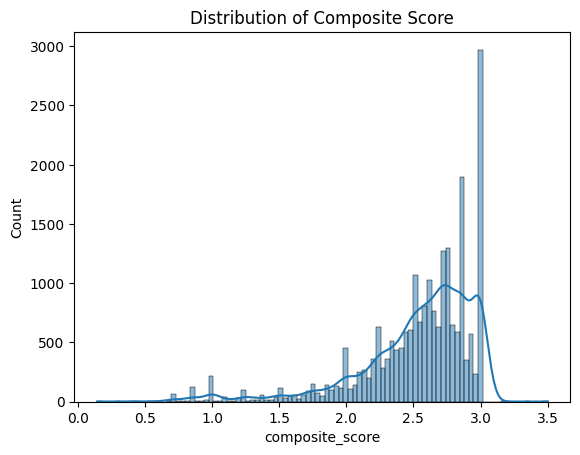

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df_yearly["composite_score"], kde=True)
plt.title("Distribution of Composite Score")
plt.show()


The distribution of composite score is skewed to the left. This means that we have more businesses with higher composite score. We must address this imbalance while using the model.

In [14]:
# Pivoting composite_score
pivot = df_yearly.pivot(index='business_name', columns='year', values='composite_score')
pivot.columns = [f"year_{col}" for col in pivot.columns]

pivot = pivot.dropna(subset=["year_2018", "year_2019", "year_2020", "year_2021"])

category_df = df_yearly[df_yearly["year"] == 2021][["business_name", "standard_category"]].drop_duplicates()

# Merging category back into pivot
pivot = pivot.merge(category_df, on="business_name", how="left")

# Change in composite score - patterns in one year gap
pivot["delta_18_19"] = pivot["year_2019"] - pivot["year_2018"]
pivot["delta_19_20"] = pivot["year_2020"] - pivot["year_2019"]
pivot["pct_change_20_21"] = ((pivot["year_2021"] - pivot["year_2020"]) / pivot["year_2020"]) * 100

# Engagement metrics
def classify_change(pct):
    if pct <= -20:
        return 0
    elif pct >= 20:
        return 2
    else:
        return 1

pivot["engagement_label"] = pivot["pct_change_20_21"].apply(classify_change)

X = pivot[["delta_18_19", "delta_19_20", "standard_category"]]
X = pd.get_dummies(X, columns=["standard_category"])
y = pivot["engagement_label"].values


In [15]:
X.shape

(5608, 30)

In [16]:
y.shape

(5608,)

In [17]:
from sklearn.model_selection import train_test_split

# train+val and test (80/20)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Split train+val into train and val (75/25 of the 80% => 60/20 overall)
X_train_full, X_val, y_train_full, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)

print(f"Train: {X_train_full.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")


Train: 3364, Val: 1122, Test: 1122


In [18]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, classification_report
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_sample_weight


In [19]:
def get_stratified_subset(X, y, fraction, random_state=42):
    splitter = StratifiedShuffleSplit(n_splits=1, train_size=fraction, random_state=random_state)
    train_idx, test_idx = next(splitter.split(X, y))

    if isinstance(X, pd.DataFrame):
        return X.iloc[train_idx], y[train_idx]
    else:
        return X[train_idx], y[train_idx]


In [20]:
def train_xgb_subset(X_train_full, y_train_full, train_fraction, X_val, y_val):
    X_train, y_train = get_stratified_subset(X_train_full, y_train_full, train_fraction)

    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

    model = XGBClassifier(
        objective='multi:softmax',
        num_class=3,
        eval_metric='mlogloss',
        random_state=42
    )
    model.fit(X_train, y_train, sample_weight=sample_weights)

    preds = model.predict(X_val)
    acc = accuracy_score(y_val, preds)
    f1 = f1_score(y_val, preds, average='macro')
    cm = confusion_matrix(y_val, preds)
    auc = roc_auc_score(y_val, model.predict_proba(X_val), multi_class='ovr')
    rep = classification_report(y_val, preds)

    return acc, f1, model


In [21]:
train_sizes = [0.2, 0.4, 0.6, 0.8, 0.99]
xgb_accuracies = []
xgb_f1s = []

X_temp, X_val, y_temp, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

for frac in train_sizes:
    acc, f1, model = train_xgb_subset(X_train_full, y_train_full, frac, X_val, y_val)
    xgb_accuracies.append(acc)
    xgb_f1s.append(f1)
    print(f"Train size: {int(frac*100)}% — Accuracy: {acc:.4f} — F1-score: {f1:.4f}")


Train size: 20% — Accuracy: 0.7941 — F1-score: 0.5438
Train size: 40% — Accuracy: 0.7807 — F1-score: 0.5492
Train size: 60% — Accuracy: 0.7852 — F1-score: 0.5910
Train size: 80% — Accuracy: 0.7620 — F1-score: 0.5871
Train size: 99% — Accuracy: 0.7576 — F1-score: 0.5761


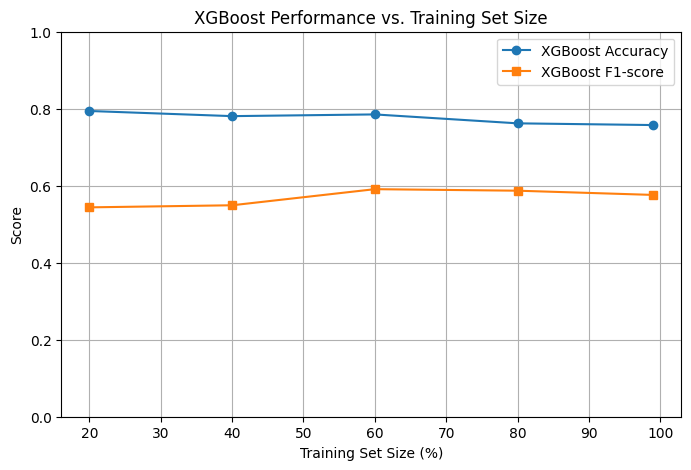

In [22]:
import matplotlib.pyplot as plt

x_vals = [int(f * 100) for f in train_sizes]

plt.figure(figsize=(8, 5))
plt.plot(x_vals, xgb_accuracies, marker='o', label="XGBoost Accuracy")
plt.plot(x_vals, xgb_f1s, marker='s', label="XGBoost F1-score")
plt.xlabel("Training Set Size (%)")
plt.ylabel("Score")
plt.title("XGBoost Performance vs. Training Set Size")
plt.legend()
plt.ylim(0, 1)
plt.grid(True)
plt.show()


In [25]:
final_preds = model.predict(X_test)

print(f"Test Set, Accuracy: {acc:.4f} — F1-score: {f1:.4f}")

Test Set, Accuracy: 0.7576 — F1-score: 0.5761


In [26]:
print(classification_report(y_test, final_preds))

              precision    recall  f1-score   support

           0       0.18      0.32      0.23        85
           1       0.90      0.80      0.85       910
           2       0.59      0.73      0.65       127

    accuracy                           0.76      1122
   macro avg       0.56      0.62      0.58      1122
weighted avg       0.81      0.76      0.78      1122



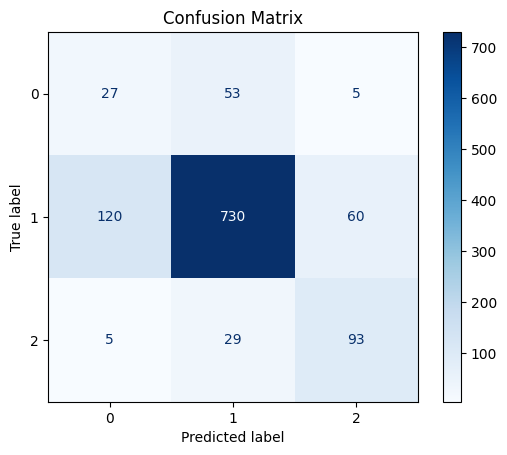

In [24]:
cm = confusion_matrix(y_test, final_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [28]:
df_10k = pd.read_parquet("gs://final_dataset_dat490/sample_reviews_stratified_10k_labeled.parquet")
df_10k.columns

Index(['gmap_id', 'customer_name', 'rating', 'reviews', 'time', 'avg_rating',
       'category', 'latitude', 'longitude', 'business_name', 'num_of_reviews',
       'state', 'standard_category', 'Monday', 'Tuesday', 'Wednesday',
       'Thursday', 'Friday', 'Saturday', 'Sunday', 'timestamp', 'week',
       'month', 'year', 'time_seconds', 'review_length', 'length_bucket',
       'chatgpt_label'],
      dtype='object')

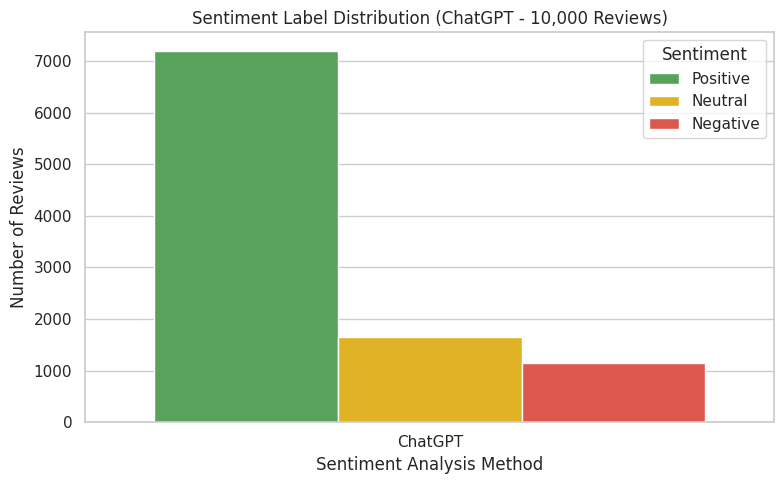

In [30]:
sns.set(style="whitegrid")

label_counts = df_10k['chatgpt_label'].value_counts().reindex(['Positive', 'Neutral', 'Negative'])

plot_df = pd.DataFrame({
    'Sentiment': label_counts.index,
    'Count': label_counts.values,
    'Method': 'ChatGPT'
})

plt.figure(figsize=(8, 5))
sns.barplot(data=plot_df, x='Method', y='Count', hue='Sentiment', palette={
    'Positive': '#4CAF50', 'Neutral': '#FFC107', 'Negative': '#F44336'
})

plt.title("Sentiment Label Distribution (ChatGPT - 10,000 Reviews)")
plt.ylabel("Number of Reviews")
plt.xlabel("Sentiment Analysis Method")
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()